In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import math
from statsmodels.stats.weightstats import ztest
from matplotlib import pyplot

In [2]:
### read in all files

## census data
census = pd.read_csv("census_demographic_data.csv", converters={'STATE':str,'COUNTY':str}, encoding='latin-1')

# for now, just going to work with all age group data (AGEGRP = 0). future work - break down by age / calculate average age
# will also only use the latest estimate from Aug 2021 (YEAR = 3)
census_all_ages = census[(census["AGEGRP"]==0) & (census["YEAR"] == 3)].copy()

# need to add a combined state+county ID column to match the county ID in the relational table
census_all_ages["County ID"] = (census_all_ages["STATE"] + census_all_ages["COUNTY"]).astype(int)

## quality metric data
quality = pd.read_excel("census_quality_metrics_county.xlsx", converters={'State':str,'County':str,"Unresolved Housing Unit (went to Count Imputation)":float,"Proxy":float,"Administrative Records":float,"Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)":float}, header=1).dropna()
#, "Unresolved Housing Unit (went to Count Imputation)":float,"Proxy":float,"Administrative Records":float,"Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)":float

# need to add a combined state+county ID column to match the county ID in the relational table
quality["County ID"] = (quality['State'] + quality["County"]).astype(int)
quality["County ID"] = quality["County ID"].astype(int)

## county district relation table
relation = pd.read_csv("county_district_relation.txt", delimiter="|")

# need to clean data to get just county and district, lots of extraneous data
relation = relation[["NAMELSAD_SLDL2022_20","GEOID_COUNTY_20","NAMELSAD_COUNTY_20"]].dropna()
relation["Short State District ID"] = relation["NAMELSAD_SLDL2022_20"].astype(str).str.extractall('(\d+)').unstack().fillna('').sum(axis=1)
#relation = relation[pd.to_numeric(relation["Short State District ID"], errors='coerce').notnull()]
relation = relation.rename({'NAMELSAD_SLDL2022_20': 'State District ID', 'GEOID_COUNTY_20': 'County ID', "NAMELSAD_COUNTY_20" : "County"}, axis=1)


In [3]:
### join together all data frames

county_data = census_all_ages.merge(quality, on='County ID', how='left')
county_district_data = county_data.merge(relation, on="County ID", how='right')
county_district_data.dropna(inplace=True)
county_district_data

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,Self-Response,Internet,"Within Self-Response, Internet",Household Interview,Proxy,Administrative Records,Population Count Only (NRFU Occupied from Household Interviews and Proxy Interviews),State District ID,County_y,Short State District ID
0,50.0,01,077,Alabama,Lauderdale County,3.0,0.0,94043.0,45416.0,48627.0,...,0.671,0.410,0.611,0.546,0.276,0.172,0.036,State House District 1,Lauderdale County,1.0
1,50.0,01,077,Alabama,Lauderdale County,3.0,0.0,94043.0,45416.0,48627.0,...,0.671,0.410,0.611,0.546,0.276,0.172,0.036,State House District 2,Lauderdale County,2.0
2,50.0,01,077,Alabama,Lauderdale County,3.0,0.0,94043.0,45416.0,48627.0,...,0.671,0.410,0.611,0.546,0.276,0.172,0.036,State House District 3,Lauderdale County,3.0
3,50.0,01,083,Alabama,Limestone County,3.0,0.0,107517.0,54050.0,53467.0,...,0.592,0.479,0.809,0.596,0.203,0.19,0.062,State House District 2,Limestone County,2.0
4,50.0,01,083,Alabama,Limestone County,3.0,0.0,107517.0,54050.0,53467.0,...,0.592,0.479,0.809,0.596,0.203,0.19,0.062,State House District 4,Limestone County,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,50.0,56,025,Wyoming,Natrona County,3.0,0.0,79555.0,40294.0,39261.0,...,0.640,0.515,0.805,0.543,0.249,0.203,0.062,State House District 57,Natrona County,57.0
8292,50.0,56,025,Wyoming,Natrona County,3.0,0.0,79555.0,40294.0,39261.0,...,0.640,0.515,0.805,0.543,0.249,0.203,0.062,State House District 58,Natrona County,58.0
8293,50.0,56,025,Wyoming,Natrona County,3.0,0.0,79555.0,40294.0,39261.0,...,0.640,0.515,0.805,0.543,0.249,0.203,0.062,State House District 59,Natrona County,59.0
8294,50.0,56,025,Wyoming,Natrona County,3.0,0.0,79555.0,40294.0,39261.0,...,0.640,0.515,0.805,0.543,0.249,0.203,0.062,State House District 62,Natrona County,62.0


In [7]:
county_district_data.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE',
       'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE',
       'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE',
       'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
       'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE',
       'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE',
       'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE',
       'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE', 'NHWAC_FEMALE',
       'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE', 'NHIAC_FEMALE',
       'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE',
       'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE',
       'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE

In [8]:
quality_stats = quality[["Proxy","Administrative Records","Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)"]].astype(float).describe()

In [9]:
# descriptive statistics for the quality metrics
quality_stats.columns = ["Proxy","Administrative Records","Population Count"]
quality_stats

,Proxy,Administrative Records,Population Count
count,2684.000000,2684.000000,2684.000000
mean,0.223188,0.172050,0.042329
std,0.058878,0.059231,0.030868
min,0.009000,0.001000,0.001000
25%,0.188000,0.138750,0.023000
50%,0.217000,0.177000,0.037000
75%,0.252000,0.208000,0.054000
max,0.527000,0.602000,0.431000


In [10]:
# create the new "quality sum" variable summing together the 3 key quality factors

county_district_data["quality_sum"] = county_district_data[['Proxy','Administrative Records','Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)']].sum(axis=1)
county_district_data["quality_sum"]

0       0.484
1       0.484
2       0.484
3       0.455
4       0.455
        ...  
8291    0.514
8292    0.514
8293    0.514
8294    0.514
8295    0.464
Name: quality_sum, Length: 7718, dtype: float64

In [11]:
# descriptive stats on quality sum factor
county_district_data["quality_sum"].astype(float).describe()

count    7718.000000
mean        0.476651
std         0.090943
min         0.154000
25%         0.415000
50%         0.484000
75%         0.541000
max         1.105000
Name: quality_sum, dtype: float64

In [12]:
# assign percentile to each district
county_district_data["percentile"] = np.nan
for x in range(len(county_district_data["quality_sum"])):
    county_district_data.iloc[x,-1] = 100-stats.percentileofscore(county_district_data["quality_sum"], county_district_data.iloc[x,-2])

In [13]:
# export to csv
county_district_data.to_csv("Local level census data with quality statistics.csv")

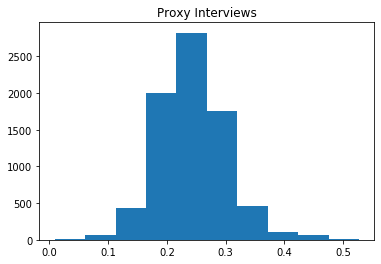

In [14]:
pyplot.hist(county_district_data["Proxy"])
pyplot.title('Proxy Interviews')
pyplot.show()

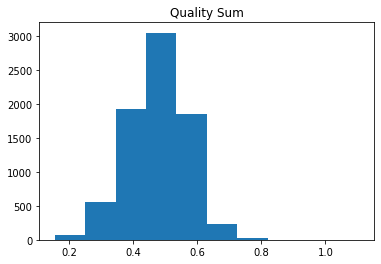

In [15]:
pyplot.hist(county_district_data["quality_sum"])
pyplot.title('Quality Sum')
pyplot.show()

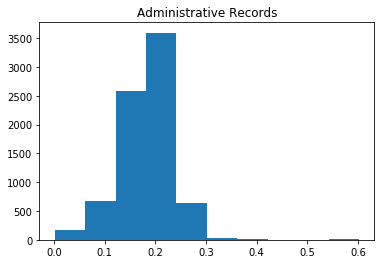

In [16]:
pyplot.hist(county_district_data['Administrative Records'])
pyplot.title('Administrative Records')
pyplot.show()

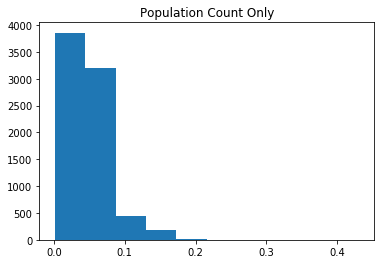

In [17]:
pyplot.hist(county_district_data['Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)'])
pyplot.title('Population Count Only')
pyplot.show()

In [30]:
# export list of districts with issues, defined here as bottom 5th percentile
bottom5 = county_district_data[county_district_data["percentile"] < 5].sort_values(by=["percentile"])
bottom5 = bottom5[["STATE","COUNTY","STNAME","CTYNAME",'State District ID',"quality_sum","percentile","Unresolved Housing Unit (went to Count Imputation)","Proxy", "Administrative Records","Population Count Only  (NRFU Occupied from Household Interviews and Proxy Interviews)"]]
bottom5.to_csv("Districts With Quality Issues, Bottom 5th Percentile.csv")

In [29]:
len(set(bottom5["COUNTY"]))

57